PyTorch provides the elegantly designed modules and classes [torch.nn](https://pytorch.org/docs/stable/nn.html),
[torch.optim](https://pytorch.org/docs/stable/optim.html),
[Dataset](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) , and [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) to help you create and train neural networks.
In order to fully utilize their power and customize
them for your problem, you need to really understand exactly what they're
doing. To develop this understanding, we will first train basic neural net
on the MNIST data set without using any features from these models; we will
initially only use the most basic PyTorch tensor functionality. Then, we will
incrementally add one feature from ``torch.nn``, ``torch.optim``, ``Dataset``, or
``DataLoader`` at a time, showing exactly what each piece does, and how it
works to make the code either more concise, or more flexible.

## MNIST data setup

(50000, 784) 5


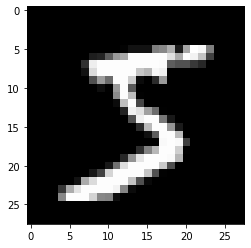

In [1]:
import pickle
import gzip
from pathlib import Path
from matplotlib import pyplot
import numpy as np

PATH = Path.home() / 'data/mnist.pkl.gz'
with gzip.open(PATH, "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")
        
pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape, y_train[0])

In [2]:
# PyTorch uses torch.tensor, rather than numpy arrays, so we need to convert our data.
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


## Neural net from scratch (no torch.nn)

For the weights, we set ``requires_grad`` **after** the initialization, since we don't want that step included in the gradient. (Note that a trailling ``_`` in PyTorch signifies that the operation is performed in-place.)

We are initializing the weights here with [Xavier initialisation](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) (by multiplying with 1/sqrt(n)).

    Q: since we don't want that step included in the gradient
    
Thanks to PyTorch’s ability to calculate gradients automatically, we can use any standard Python function (or callable object) as a model! So let’s just write a plain matrix multiplication and broadcasted addition to create a simple linear model. 

In [3]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)  # the @ stands for the dot product operation

In [4]:
# Call our function on one batch of data (in this case, 64 images). This is one forward pass.
# Note that our predictions won't be any better than random at this stage, 
# since we start with random weights
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions

# The preds tensor contains not only the tensor values, but also a gradient function. 
# We'll use this later to do backprop.
print(preds[0], preds.shape)

tensor([-2.2472, -2.3293, -2.1307, -2.6807, -2.5055, -2.0581, -1.7107, -2.5361,
        -2.7496, -2.5710], grad_fn=<SelectBackward>) torch.Size([64, 10])


In [9]:
# Implement *negative log-likelihood* to use as the loss function 
# 前面 log_softmax 中，计算 softmax 时取了对数，这里只加一个负号
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()
loss_func = nll

# Let’s check our loss with our random model, so we can see if we improve after a backprop pass later.
yb = y_train[0:bs]
print(loss_func(preds, yb))

def accuracy(out, yb):
    '''to calculate the accuracy of our model'''
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()
print(accuracy(preds, yb))

tensor(2.3058, grad_fn=<NegBackward>)
tensor(0.0781)


In [10]:
from IPython.core.debugger import set_trace

lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #  set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

In [11]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NegBackward>) tensor(1.)


## Using torch.nn.functional

 ``F.cross_entropy`` combines log_softmax and nll_loss in a single function.


In [22]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward>) tensor(1.)


## Refactor using nn.Module

Next up, we’ll use ``nn.Module`` and ``nn.Parameter``, for a clearer and more concise training loop. In this case, we want to create a class that holds our weights, bias, and method for the forward step. 

In [26]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))
        
    def forward(self, xb):
        return xb @ self.weights + self.bias
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            
            # take advantage of model.parameters() and model.zero_grad() 
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()
print(loss_func(model(xb), yb))


tensor(2.4000, grad_fn=<NllLossBackward>)
tensor(0.0827, grad_fn=<NllLossBackward>)


## Refactor using nn.Linear
Instead of manually defining and initializing ``self.weights`` and ``self.bias``, and calculating ``xb  @ self.weights + self.bias``, we will instead use the Pytorch class
[nn.Linear](https://pytorch.org/docs/stable/nn.html#linear-layers) for a linear layer.

In [27]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)
        
    def forward(self, xb):
        return self.lin(xb)
    
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

fit()
print(loss_func(model(xb), yb))

tensor(2.3755, grad_fn=<NllLossBackward>)
tensor(0.0806, grad_fn=<NllLossBackward>)


## Refactor using optim

Pytorch also has a package with various optimization algorithms, ``torch.optim``.
We can use the ``step`` method from our optimizer to take a forward step, instead
of manually updating each parameter.

In [28]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i: end_i]
        yb = y_train[start_i: end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2984, grad_fn=<NllLossBackward>)
tensor(0.0801, grad_fn=<NllLossBackward>)


## Refactor using Dataset
PyTorch has an abstract Dataset class.  A Dataset can be anything that has
a ``__len__`` function (called by Python's standard ``len`` function) and
a ``__getitem__`` function as a way of indexing into it.

PyTorch's [TensorDataset](https://pytorch.org/docs/stable/_modules/torch/utils/data/dataset.html#TensorDataset)
is a Dataset wrapping tensors. 

In [29]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        # Previously, we had to iterate through minibatches of x and y values separately.
        # Now, we can do these two steps together
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0812, grad_fn=<NllLossBackward>)


## Refactor using DataLoader

Pytorch's ``DataLoader`` is responsible for managing batches. 

In [30]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl: # (xb, yb) are loaded automatically from the data loader
        pred = model(xb)
        loss = loss_func(pred, yb)
        
        loss.backward()
        opt.step()
        opt.zero_grad()
        
print(loss_func(model(xb), yb))

tensor(0.0809, grad_fn=<NllLossBackward>)


## Add validation

Shuffling the training data is
[important](https://www.quora.com/Does-the-order-of-training-data-matter-when-training-neural-networks)
to prevent correlation between batches and overfitting. On the other hand, the
validation loss will be identical whether we shuffle the validation set or not.
Since shuffling takes extra time, it makes no sense to shuffle the validation data.

We'll use a batch size for the validation set that is twice as large as
that for the training set. This is because the validation set does not
need backpropagation and thus takes less memory (it doesn't need to
store the gradients). We take advantage of this to use a larger batch
size and compute the loss more quickly.

    Q: 为什么训练集需要 shuffing 而验证集不需要？

In [33]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    # TODO 
    # (Note that we always call ``model.train()`` before training, and ``model.eval()``
    # before inference, because these are used by layers such as ``nn.BatchNorm2d``
    # and ``nn.Dropout`` to ensure appropriate behaviour for these different phases.)
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.3001)
1 tensor(0.3007)


## Create fit() and get_data()

Since we go through a similar
process twice of calculating the loss for both the training set and the
validation set, let's make that into its own function, ``loss_batch``, which
computes the loss for one batch.

In [39]:
import numpy as np

# We pass an optimizer in for the training set, and use it to perform backprop. 
# For the validation set, we don’t pass an optimizer, so the method doesn’t perform backprop.
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(xb)

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)
            
        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb)
                                 for xb, yb in valid_dl])
        valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        
        print(epoch, valid_loss)
    
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3308257801532745
1 0.3552557683467865


## Switch to CNN

We will use Pytorch's predefined
[Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) class
as our convolutional layer. We define a CNN with 3 convolutional layers.
Each convolution is followed by a ReLU.  At the end, we perform an
average pooling.  (Note that ``view`` is PyTorch's version of numpy's
``reshape``)

    Q: momentum
    Q: 3 convolutional layers

In [66]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1) # TODO stride, padding
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        
    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28) # vector 转换成 CNN 需要的 2d image
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.294937638092041
1 0.21888527011871337


## view

A ``Sequential`` object runs each of the modules contained within it, in a
sequential manner. This is a simpler way of writing our neural network.

To take advantage of this, we need to be able to easily define a
**custom layer** from a given function.  For instance, PyTorch doesn't
have a `view` layer, and we need to create one for our network. ``Lambda``
will create a layer that we can then use when defining a network with
``Sequential``.

In [48]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
        
    def forward(self, x):
        return self.func(x)
    
def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.35160538264513014
1 0.3173688180208206


## Wrapping DataLoader

Our CNN is fairly concise, but it only works with MNIST, because:
 - It assumes the input is a 28\*28 long vector
 - It assumes that the final CNN grid size is 4\*4 (since that's the average
pooling kernel size we used)

Let's get rid of these two assumptions, so our model works with any 2d
single channel image. First, we can remove the initial Lambda layer but
moving the data preprocessing into a generator.

Next, we can replace ``nn.AvgPool2d`` with ``nn.AdaptiveAvgPool2d``, which
allows us to define the size of the *output* tensor we want, rather than
the *input* tensor we have. As a result, our model will work with any
size input.

In [68]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func
        
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3320544507980347
1 0.23376555967330934


## Using your GPU

In [70]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.20238498213291167
1 0.18569903119504452


## Closing thoughts

Closing thoughts
-----------------

We now have a general data pipeline and training loop which you can use for
training many types of models using Pytorch.

Of course, there are many things you'll want to add, such as data augmentation,
hyperparameter tuning, monitoring training, transfer learning, and so forth.
These features are available in the fastai library, which has been developed
using the same design approach shown in this tutorial, providing a natural
next step for practitioners looking to take their models further.

We promised at the start of this tutorial we'd explain through example each of
``torch.nn``, ``torch.optim``, ``Dataset``, and ``DataLoader``. So let's summarize
what we've seen:

 - **torch.nn**

   + ``Module``: creates a callable which behaves like a function, but can also
     contain state(such as neural net layer weights). It knows what ``Parameter`` (s) it
     contains and can zero all their gradients, loop through them for weight updates, etc.
   + ``Parameter``: a wrapper for a tensor that tells a ``Module`` that it has weights
     that need updating during backprop. Only tensors with the `requires_grad` attribute set are updated
   + ``functional``: a module(usually imported into the ``F`` namespace by convention)
     which contains activation functions, loss functions, etc, as well as non-stateful
     versions of layers such as convolutional and linear layers.
 - ``torch.optim``: Contains optimizers such as ``SGD``, which update the weights
   of ``Parameter`` during the backward step
 - ``Dataset``: An abstract interface of objects with a ``__len__`` and a ``__getitem__``,
   including classes provided with Pytorch such as ``TensorDataset``
 - ``DataLoader``: Takes any ``Dataset`` and creates an iterator which returns batches of data.

